# PoseNet for Self-Localization Task on Apolloscape Dataset

PoseNet implementation on Apolloscape dataset. It's a part of the localization methods exploration for Apolloscape Self-Localization Challenge on [ECCV 2018](http://apolloscape.auto/ECCV/challenge.html)

In [1]:
# Load all dependency
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torchviz
import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape
from datasets.tum import TUM

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params, quaternion_angular_error

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime
import random

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

`APOLLO_PATH` is a location with unpacked Apolloscape datasets, e.g. `$APOLLO_PATH/road02_seg` or `$APOLLO_PATH/zpark`. Download data from [Apolloscape page](http://apolloscape.auto/scene.html) and unpack it to the `APOLLO_PATH` dir. Let's we've symbolically linked `APOLLO_PATH` folder to `./data/apolloscape`.

In [2]:
APOLLO_PATH = "/home/sufferlinux/Downloads/derbyml"
# APOLLO_PATH = "/home/hsuan/Desktop"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
#     transforms.Resize((224, 672)),
    transforms.ToTensor(),
    normalize
])

# 4/23	Train	1,2,3,4,6,7,8,10,11
# 	Test	9,12,13,15	



pretrained = True
stereo = False
shuffle = True

batch_size = 64

# train_set = ['sequence_01', 'sequence_03', 'sequence_04', 'sequence_05', 'sequence_06', 
#                'sequence_07', 'sequence_08', 'sequence_09', 'sequence_10']
# train_set = ['sequence_01', 'sequence_06', 
#                'sequence_07', 'sequence_08', 'sequence_09', 'sequence_10', 'sequence_11', 
#                'sequence_12', 'sequence_13', 'sequence_15']
# train_set = [ 'sequence_11', 
#                'sequence_12', 'sequence_13', 'sequence_14', 'sequence_15']

# train_set = ['sequence_01', 'sequence_02']

train_set = ['sequence_01', 'sequence_03', 'sequence_06', 'sequence_07', 'sequence_08', 'sequence_09',
               'sequence_10', 'sequence_12', 'sequence_14', 'sequence_15']


train_list = [ TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=k, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)\
                             for k in train_set]

# train_record = "sequence_01"
# train_dataset = TUM(root=os.path.join(APOLLO_PATH), road="TUM",
#                              transform=transform, record=train_record, normalize_poses=True,
#                              pose_format='quat', train=True, cache_transform=True, stereo=stereo)
experiment_name = "NF_50_V2_1113_2000_3000_lr_6"
val_record = "sequence_02"
val_dataset = TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True, stereo=stereo)

# test_set = ['sequence_02', 'sequence_07', 'sequence_10', 'sequence_13']
test_set = ['sequence_02', 'sequence_11', 'sequence_13']
test_list = [ TUM(root=os.path.join(APOLLO_PATH), road="TUM",
                             transform=transform, record=k, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)\
                             for k in test_set]

#7,11,15 bad for val
# print(train_dataset)
print(val_dataset)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2) 
train_dataloader_list = [ DataLoader(i, batch_size=batch_size, shuffle=shuffle, num_workers=2) 
                          for i in train_list]
test_dataloader_list = [ DataLoader(i, batch_size=batch_size, shuffle=shuffle, num_workers=2) 
                          for i in test_list]
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)


pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
pose_dir =  /home/sufferlinux/Downloads/derbyml/TUM/sequences
Dataset: TUM
    Road: TUM
    Record: sequence_02
    Train: False
    Normalize Poses: True
    Stereo: False
    Length: 1592 of 

## Draw Train and Val datasets

Visualize poses from `train` and `val` datasets to check that it covers all val path.

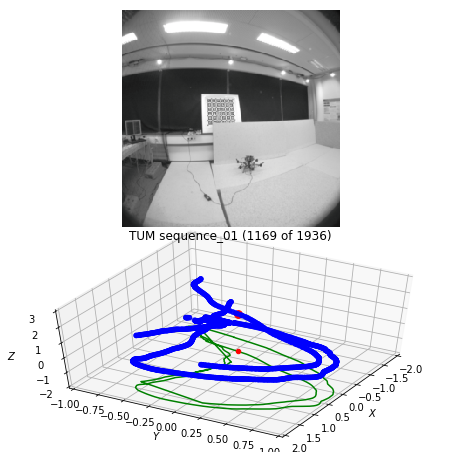

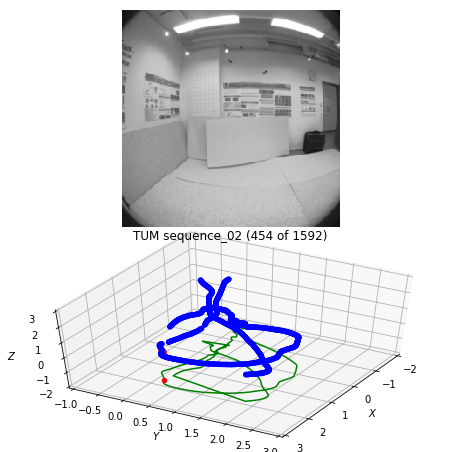

In [3]:
# Draw datasets
# draw_record(train_dataset)
draw_record(train_list[0])
plt.show()

draw_record(val_dataset)
plt.show()


## Device set up

Determine the primary device and use it for training/validation.

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

Train function runs one epoch through training data.

In [5]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True,
          poses_mean=None, poses_std=None, stereo = True):
    
    # switch model to training
    model.train()
    
    losses = AverageMeter()
    
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
                else batch_images.size(0))
        
        
        # move data to cpu & numpy
        if stereo:
            bp = [x.detach().cpu().numpy() for x in batch_poses]
            outp = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *bp))
            pred_poses = np.vstack((pred_poses, *outp))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))
        
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))

            
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     if unnorm:
#         print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
#     print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
#     print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

            
    if print_sum:
        print('Ep: [{}/{}]\tTrain Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s\t{criterion_sx:.5f}:{criterion_sq:.5f}'.format(
            epoch, max_epoch - 1, losses.avg, np.mean(t_loss), np.mean(q_loss),
            (time.time() - epoch_time), criterion_sx=criterion.sx.data[0], criterion_sq=criterion.sq.data[0]))
        

In [6]:
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True, 
             poses_mean=None, poses_std=None, stereo=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            
            if stereo:
                batch_images = [x.to(device) for x in batch_images]
                batch_poses = [x.to(device) for x in batch_poses]
            else:
                batch_images = batch_images.to(device)
                batch_poses = batch_poses.to(device)
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
                    else batch_images.size(0))
                    # move data to cpu & numpy
            if stereo:
                bp = [x.detach().cpu().numpy() for x in batch_poses]
                outp = [x.detach().cpu().numpy() for x in out]
                gt_poses = np.vstack((gt_poses, *bp))
                pred_poses = np.vstack((pred_poses, *outp))
            else:
                bp = batch_poses.detach().cpu().numpy()
                outp = out.detach().cpu().numpy()
                gt_poses = np.vstack((gt_poses, bp))
                pred_poses = np.vstack((pred_poses, outp))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
    
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])           
    
    if print_sum:
        # print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
        #                                                                        (time.time() - epoch_time)))
        print('Epoch: [{}]\tValidation Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s\t **********'.format(
            epoch, losses.avg, np.mean(t_loss), np.mean(q_loss),(time.time() - epoch_time)))

## Create Model, Criterion and Optimizer

PoseNet implementation is a ResNet based feature extractor that ends with custom fully-connected regressor layers for translation (3D pose) and rotation (quaternion).

In [7]:
# Create pretrained feature extractor
# feature_extractor = models.resnet18(pretrained=True)
# feature_extractor = models.resnet34(pretrained=pretrained)
feature_extractor = models.resnet50(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = PoseNet(feature_extractor, num_features=num_features, pretrained=pretrained, freeze=False)
model = model.to(device)

# Criterion
# criterion = PoseNetCriterion(stereo=stereo, beta=500.0)
criterion = PoseNetCriterion(stereo=stereo, learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    param_list.append({'params': criterion.parameters()})

# Create optimizer
optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

It helps to continue training later or just use it for the inference.

In [8]:
#Restore from checkpoint
# checkpoint_file = '_checkpoints/20180823_085404_zpark_posenet_L1_resnet34p_2048_e2880.pth.tar'
checkpoint_file = '_checkpoints/20200426_025040_nb_NF_50_V2_1113_2000_2500_lr_6_e2500.pth.tar'


if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']
        if 'criterion_state_dict' in checkpoint:
            criterion.load_state_dict(checkpoint['criterion_state_dict'])
            print('Loaded criterion params.')
            


Loading from checkpoint: _checkpoints/20200426_025040_nb_NF_50_V2_1113_2000_2500_lr_6_e2500.pth.tar
Loaded criterion params.


## Run Training

Training loop that runs for `n_epochs` with validation every `val_freq` epochs.

In [ ]:
if 'start_epoch' not in locals():
    start_epoch = 0
optimizer = optim.Adam(params=param_list, lr=1e-6, weight_decay=0.0004)    
n_epochs = start_epoch + 500
train_dataloader = train_dataloader_list[0]
print('Training ...')
c_freq = 3
val_freq = 20
dset_num = np.arange(len(train_list))
for e in range(start_epoch, n_epochs):
    if e % c_freq == 0:
        idx = int (random.choice(dset_num))
        train_dataloader = train_dataloader_list[idx]
#         print("========= Train on Dataset =======", record_list[idx])
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0,
            poses_mean=train_dataloader.dataset.poses_mean, 
            poses_std=train_dataloader.dataset.poses_std, stereo=stereo)
    if e % val_freq == 0:
#         end = time.time()
#         validate(val_dataloader, model, criterion, e, log_freq=0, stereo=stereo)
        validate(val_dataloader, model, criterion, e, log_freq=0, poses_mean=val_dataset.poses_mean, 
                poses_std=val_dataset.poses_std, stereo=stereo)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Ep: [2500/2999]	Train Loss: -3.632	Te: 0.309	Re: 3.732	 Et: 10.95s	0.46145:-3.67752
Epoch: [2500]	Validation Loss: -2.719	Te: 1.044	Re: 10.107	 Et: 3.10s	 **********
Ep: [2501/2999]	Train Loss: -3.639	Te: 0.287	Re: 3.424	 Et: 10.55s	0.46172:-3.67783
Ep: [2502/2999]	Train Loss: -3.557	Te: 0.537	Re: 6.810	 Et: 8.69s	0.46207:-3.67807
Ep: [2503/2999]	Train Loss: -3.586	Te: 0.504	Re: 5.395	 Et: 8.62s	0.46237:-3.67832
Ep: [2504/2999]	Train Loss: -3.564	Te: 0.512	Re: 5.243	 Et: 8.58s	0.46266:-3.67856
Ep: [2505/2999]	Train Loss: -3.630	Te: 0.363	Re: 3.530	 Et: 10.09s	0.46288:-3.67886
Ep: [2506/2999]	Train Loss: -3.641	Te: 0.305	Re: 3.198	 Et: 10.01s	0.46304:-3.67917
Ep: [2507/2999]	Train Loss: -3.644	Te: 0.316	Re: 3.044	 Et: 10.04s	0.46320:-3.67948
Ep: [2508/2999]	Train Loss: -3.587	Te: 0.515	Re: 5.354	 Et: 8.56s	0.46346:-3.67973
Ep: [2509/2999]	Train Loss: -3.591	Te: 0.487	Re: 5.238	 Et: 8.75s	0.46375:-3.67997
Ep: [2510/2999]	Train Loss: -3.590	Te: 0.499	Re: 5.056	 Et: 8.75s	0.46

Ep: [2593/2999]	Train Loss: -3.658	Te: 0.291	Re: 3.786	 Et: 4.77s	0.48021:-3.70220
Ep: [2594/2999]	Train Loss: -3.655	Te: 0.288	Re: 3.784	 Et: 4.85s	0.48027:-3.70234
Ep: [2595/2999]	Train Loss: -3.655	Te: 0.368	Re: 3.940	 Et: 10.19s	0.48051:-3.70265
Ep: [2596/2999]	Train Loss: -3.667	Te: 0.311	Re: 3.089	 Et: 10.00s	0.48069:-3.70295
Ep: [2597/2999]	Train Loss: -3.669	Te: 0.299	Re: 3.024	 Et: 10.36s	0.48085:-3.70326
Ep: [2598/2999]	Train Loss: -3.618	Te: 0.348	Re: 5.411	 Et: 4.53s	0.48094:-3.70339
Ep: [2599/2999]	Train Loss: -3.641	Te: 0.302	Re: 4.452	 Et: 4.27s	0.48101:-3.70352
Ep: [2600/2999]	Train Loss: -3.647	Te: 0.294	Re: 4.266	 Et: 4.35s	0.48108:-3.70365
Epoch: [2600]	Validation Loss: -2.683	Te: 1.037	Re: 11.322	 Et: 2.91s	 **********
Ep: [2601/2999]	Train Loss: -3.654	Te: 0.315	Re: 3.488	 Et: 9.86s	0.48126:-3.70395
Ep: [2602/2999]	Train Loss: -3.670	Te: 0.304	Re: 2.925	 Et: 10.01s	0.48143:-3.70425
Ep: [2603/2999]	Train Loss: -3.669	Te: 0.296	Re: 2.926	 Et: 9.85s	0.48159:-3.70456
E

Ep: [2687/2999]	Train Loss: -3.640	Te: 0.482	Re: 4.959	 Et: 8.61s	0.49976:-3.72635
Ep: [2688/2999]	Train Loss: -3.672	Te: 0.342	Re: 3.742	 Et: 4.77s	0.49990:-3.72649
Ep: [2689/2999]	Train Loss: -3.685	Te: 0.290	Re: 3.440	 Et: 4.83s	0.49998:-3.72663
Ep: [2690/2999]	Train Loss: -3.684	Te: 0.277	Re: 3.423	 Et: 4.87s	0.50004:-3.72677
Ep: [2691/2999]	Train Loss: -3.680	Te: 0.311	Re: 4.191	 Et: 10.78s	0.50020:-3.72708
Ep: [2692/2999]	Train Loss: -3.689	Te: 0.280	Re: 3.320	 Et: 10.57s	0.50034:-3.72739
Ep: [2693/2999]	Train Loss: -3.687	Te: 0.287	Re: 3.287	 Et: 10.68s	0.50048:-3.72770
Ep: [2694/2999]	Train Loss: -3.676	Te: 0.286	Re: 4.566	 Et: 4.82s	0.50055:-3.72784
Ep: [2695/2999]	Train Loss: -3.684	Te: 0.280	Re: 3.730	 Et: 4.79s	0.50061:-3.72798
Ep: [2696/2999]	Train Loss: -3.687	Te: 0.286	Re: 3.465	 Et: 4.75s	0.50067:-3.72812
Ep: [2697/2999]	Train Loss: -3.656	Te: 0.453	Re: 4.787	 Et: 10.55s	0.50102:-3.72844
Ep: [2698/2999]	Train Loss: -3.672	Te: 0.412	Re: 3.951	 Et: 10.66s	0.50134:-3.72875

Ep: [2781/2999]	Train Loss: -3.628	Te: 0.518	Re: 6.395	 Et: 5.73s	0.51946:-3.75235
Ep: [2782/2999]	Train Loss: -3.678	Te: 0.419	Re: 4.793	 Et: 5.63s	0.51968:-3.75251
Ep: [2783/2999]	Train Loss: -3.682	Te: 0.409	Re: 4.501	 Et: 5.57s	0.51987:-3.75268
Ep: [2784/2999]	Train Loss: -3.700	Te: 0.306	Re: 3.903	 Et: 10.59s	0.52006:-3.75299
Ep: [2785/2999]	Train Loss: -3.715	Te: 0.280	Re: 3.204	 Et: 10.64s	0.52020:-3.75330
Ep: [2786/2999]	Train Loss: -3.716	Te: 0.281	Re: 3.205	 Et: 10.54s	0.52033:-3.75361
Ep: [2787/2999]	Train Loss: -3.675	Te: 0.343	Re: 4.865	 Et: 4.49s	0.52041:-3.75374
Ep: [2788/2999]	Train Loss: -3.694	Te: 0.321	Re: 4.205	 Et: 4.51s	0.52049:-3.75387
Ep: [2789/2999]	Train Loss: -3.697	Te: 0.293	Re: 4.099	 Et: 4.49s	0.52056:-3.75400
Ep: [2790/2999]	Train Loss: -3.620	Te: 0.564	Re: 6.576	 Et: 8.59s	0.52100:-3.75424
Ep: [2791/2999]	Train Loss: -3.662	Te: 0.508	Re: 5.320	 Et: 8.54s	0.52135:-3.75448
Ep: [2792/2999]	Train Loss: -3.666	Te: 0.496	Re: 5.133	 Et: 8.45s	0.52169:-3.75473
E

In [ ]:
# Save checkpoint
# n_epochs = 4203
save_checkpoint(model, optimizer, criterion, 'nb_{}'.format(experiment_name), n_epochs)

In [ ]:
# if 'start_epoch' not in locals():
#     start_epoch = 0
# # optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0004)    
# n_epochs = start_epoch + 100

# print('Training ...')
# val_freq = 2
# dset_num = np.arange(len(train_list))
# for e in range(start_epoch, n_epochs):
#     for idx, dset in enumerate(train_dataloader_list):
#         train_dataloader = dset
#         train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0,
#                 poses_mean=train_dataloader.dataset.poses_mean, 
#                 poses_std=train_dataloader.dataset.poses_std, stereo=stereo)
#     if e % val_freq == 0:
# #         end = time.time()
# #         validate(val_dataloader, model, criterion, e, log_freq=0, stereo=stereo)
#         validate(val_dataloader, model, criterion, e, log_freq=0, poses_mean=val_dataset.poses_mean, 
#                 poses_std=val_dataset.poses_std, stereo=stereo)
# #         random.shuffle(train_dataloader_list)

# start_epoch = n_epochs

# print('n_epochs = {}'.format(n_epochs))


## Test Model Error on Validation and Train Datasets

Calculate translation and rotation error of the predicted poses on train and validation datasets.

In [ ]:
def model_results_pred_gt(model, dataloader, poses_mean, poses_std, stereo=True):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)


        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        # move data to cpu & numpy
        if stereo:
            batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
            out = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *batch_poses))
            pred_poses = np.vstack((pred_poses, *out))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))


        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses


# # Get mean and std from dataset
# poses_mean = val_dataset.poses_mean
# poses_std = val_dataset.poses_std



# print('\n=== Test Training Dataset ======')
# pred_poses, gt_poses = model_results_pred_gt(model, train_dataloader, poses_mean, poses_std, stereo=stereo)

# pred_all = [ model_results_pred_gt(model, k, poses_mean, poses_std, stereo=stereo) \
#                                                          for k in train_dataloader_list]

# print('gt_poses = {}'.format(gt_poses.shape))
# print('pred_poses = {}'.format(pred_poses.shape))
# t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
# q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

# print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
# print('Translation(T) error in meters and Rotation(R) error in degrees:')
# print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
# print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# # Save for later visualization
# pred_poses_train = pred_poses
# gt_poses_train = gt_poses


# print('\n=== Test Validation Dataset ======')
# pred_poses, gt_poses = model_results_pred_gt(model, val_dataloader, poses_mean, poses_std, stereo=stereo)

# print('gt_poses = {}'.format(gt_poses.shape))
# print('pred_poses = {}'.format(pred_poses.shape))
# t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
# q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

# print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
# print('Translation(T) error in meters and Rotation(R) error in degrees:')
# print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
# print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# # Save for later visualization
# pred_poses_val = pred_poses
# gt_poses_val = gt_poses



In [ ]:
def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    plt.legend(['Pred_Pose','GT_Pose'])
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()

    
# print(pred_poses_train)
# print(gt_poses_train)

# Draw predicted vs ground truth poses
# draw_pred_gt_poses(pred_poses_train, gt_poses_train)
# plt.title('PoseNet on Train Dataset')
# plt.show()


# draw_pred_gt_poses(pred_poses_val, gt_poses_val)
# plt.title('PoseNet on Validation Dataset')
# plt.show()



### Visualize Prediction and Ground Truth Poses

Draw ground truth in `blue` and predictions in `red` colors.

# Plot Testing Dataset

In [ ]:
pred_test = [ model_results_pred_gt(model, k, k.dataset.poses_mean, k.dataset.poses_std, stereo=stereo) \
                                                      for k in test_dataloader_list]
for i, pred in enumerate(pred_test):
    draw_pred_gt_poses(pred[0], pred[1])
    title = 'PoseNet on Test Dataset ' + test_set[i]
    plt.title(title)
    plt.show()
    pred_poses, gt_poses = pred[0], pred[1]
    print('gt_poses = {}'.format(gt_poses.shape))
    print('pred_poses = {}'.format(pred_poses.shape))
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
    print('Translation(T) error in meters and Rotation(R) error in degrees:')
    print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
    print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))
    print('--------------end--------------')

# Plot Training Dataset

In [ ]:
pred_train = [ model_results_pred_gt(model, k, k.dataset.poses_mean, k.dataset.poses_std, stereo=stereo) \
                                                      for k in train_dataloader_list]
for i, pred in enumerate(pred_train):
    draw_pred_gt_poses(pred[0], pred[1])
    title = 'PoseNet on Train Dataset ' + train_set[i]
    plt.title(title)
    plt.show()
    pred_poses, gt_poses = pred[0], pred[1]
    print('gt_poses = {}'.format(gt_poses.shape))
    print('pred_poses = {}'.format(pred_poses.shape))
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
    print('Translation(T) error in meters and Rotation(R) error in degrees:')
    print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
    print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))
    print('--------------end--------------')

##Save Model Checkpoint

In [ ]:
# Save checkpoint
# n_epochs = 4203
save_checkpoint(model, optimizer, criterion, 'nb_{}'.format(experiment_name), n_epochs)